In [43]:
# ===================== Cell 1: 基础导入 & 加载配置 =====================
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.exp_config import get_config
from data_provider.data_loader import DataModule
from exp.exp_model import Model

# ---- 先拿一个基础配置，用来跑 DataModule（diff=0）----
config0 = get_config('LZHModelConfig')
config0.model = 'lzhmodel'
config0.bs = 1          # 只展示一个样本
config0.diff = 0        # 显式指定：不扩散

device = config0.device
print("Using device:", device)

<module 'module.name' from 'configs/LZHModelConfig.py'> LZHModelConfig
Using device: cuda


In [44]:
# ===================== Cell 2: DataModule & 两个模型（diff=0 / diff=1） =====================

# log 是为了让 DataModule 里 print 不报错
class DummyLogger:
    def only_print(self, msg):
        print(msg)

config0.log = DummyLogger()

# 构建 DataModule（会自动 load_data + 切分 + DataLoader）
datamodule = DataModule(config0)

# --------- 模型 A：diff=0（不扩散），得到 y_hat0 ----------
model0 = Model(config0).to(device)
model0.eval()

ckpt_diff0 = "./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff0_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt"
state_dict0 = torch.load(ckpt_diff0, map_location=device)
model0.load_state_dict(state_dict0)
print("Loaded diff=0 checkpoint from:", ckpt_diff0)

# --------- 模型 B：diff=1（扩散），得到 x_hat1 与 y_hat1 ----------
config1 = get_config('LZHModelConfig')
config1.model = 'lzhmodel'
config1.bs = 1
config1.diff = 1         # 开启扩散
config1.device = device  # 保持与 config0 一致

model1 = Model(config1).to(device)
model1.eval()

ckpt_diff1 = "./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff1_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt"
state_dict1 = torch.load(ckpt_diff1, map_location=device)
model1.load_state_dict(state_dict1)
print("Loaded diff=1 checkpoint from:", ckpt_diff1)


Train_length : 36696 Valid_length : 5078 Test_length : 10349
Loaded diff=0 checkpoint from: ./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff0_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt
<module 'module.name' from 'configs/LZHModelConfig.py'> LZHModelConfig
Loaded diff=1 checkpoint from: ./checkpoints/lzhmodel/Datasetweather_Modellzhmodel_Density0.700_dmodel128_Rank40_diff1_SeqLen96_PredLen96_NoiseSteps40_NoiseScale1.0_Lamda0.5_round_0.pt


In [47]:
# ===================== Cell 3: 取一个 batch，计算 x_hat1, y_hat0, y_hat1 =====================

# 从 test_loader 里取一个 batch（因为 shuffle=False，可视为“第一个样本”）
test_batch = next(iter(datamodule.test_loader))
# weather: x, x_mark, y
x, x_mark, y = [t.to(device) for t in test_batch]

print("x shape:", x.shape)        # [B, seq_len, C_x]
print("x_mark shape:", x_mark.shape)
print("y shape:", y.shape)        # [B, pred_len, C_y]

with torch.no_grad():
    # --- 模型 A（diff=0）：只做正常预测，得到 y_hat0 ---
    out0 = model0(x, x_mark)
    y_hat0 = out0[0] if isinstance(out0, tuple) else out0

    # --- 模型 B（diff=1）：先对 x 做扩散，得到 x_hat1 ---
    x_hat1 = model1.model.diffusion_forward(x)

    # 再正常前向，得到 y_hat1
    out1 = model1(x, x_mark)
    y_hat1 = out1[0] if isinstance(out1, tuple) else out1

print("x_hat1 shape:", x_hat1.shape)
print("y_hat0 shape:", y_hat0.shape)
print("y_hat1 shape:", y_hat1.shape)
print("model0.model.use_diff =", model0.model.use_diff)
print("model1.model.use_diff =", model1.model.use_diff)






x shape: torch.Size([1, 96, 21])
x_mark shape: torch.Size([1, 96, 4])
y shape: torch.Size([1, 96, 21])
x_hat1 shape: torch.Size([1, 96, 21])
y_hat0 shape: torch.Size([1, 96, 21])
y_hat1 shape: torch.Size([1, 96, 21])
model0.model.use_diff = False
model1.model.use_diff = False


Figure saved to: ./resultsPNG/figures\lzhmodel_diff0_vs_diff1_20251201-223245.png


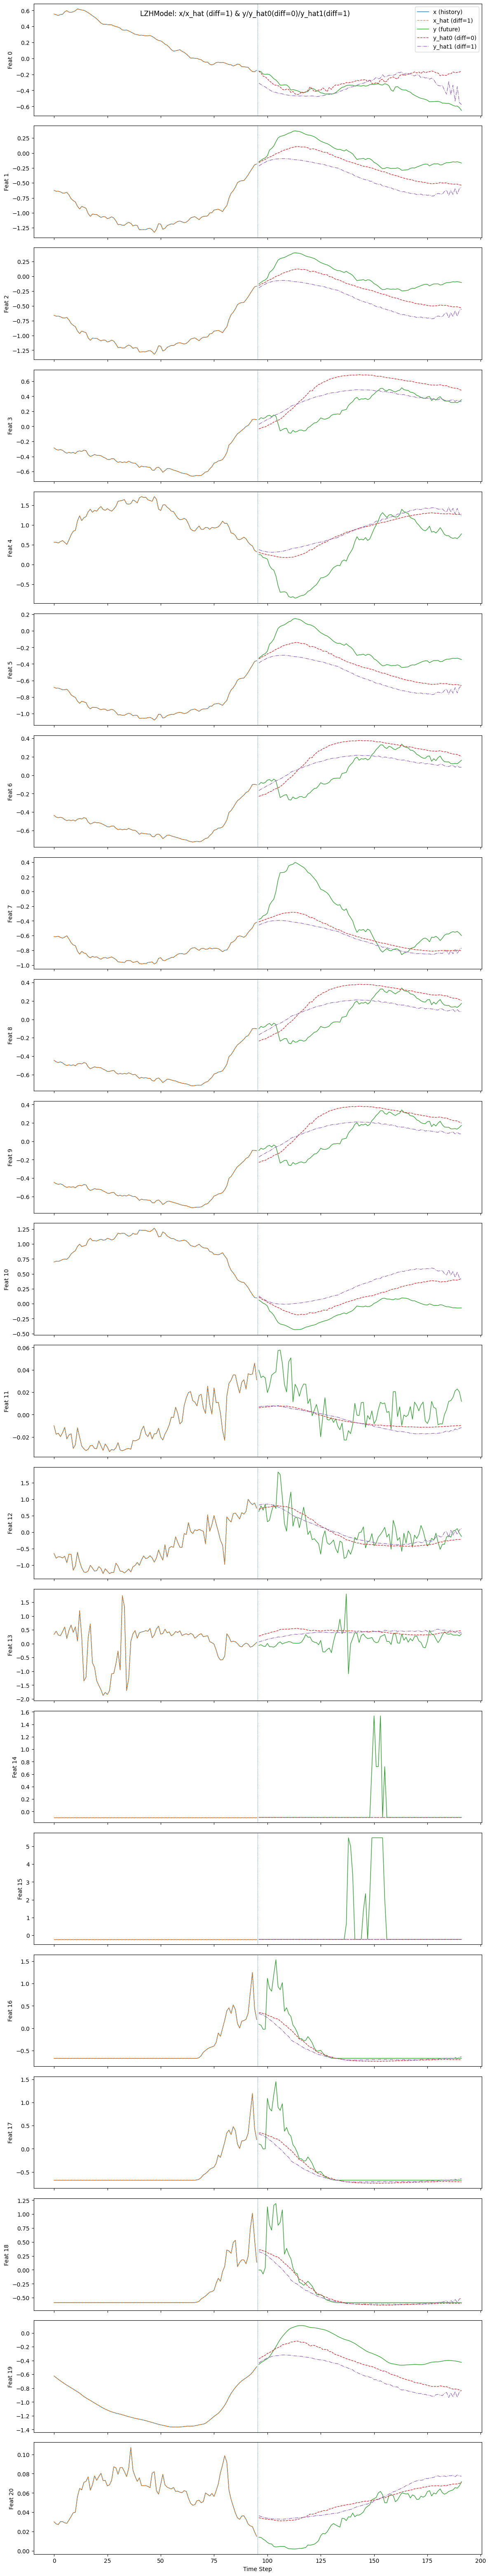

In [29]:
# ===================== Cell 4: 抽取 batch[0] 的全部通道并可视化 + 保存一张图 =====================
import os
from datetime import datetime

# Tensor -> numpy，只取 batch[0]
x_np      = x[0].detach().cpu().numpy()         # [seq_len, C]
x_hat1_np = x_hat1[0].detach().cpu().numpy()    # [seq_len, C]
y_np      = y[0].detach().cpu().numpy()         # [pred_len, C]
y_hat0_np = y_hat0[0].detach().cpu().numpy()    # [pred_len, C]
y_hat1_np = y_hat1[0].detach().cpu().numpy()    # [pred_len, C]

seq_len   = x_np.shape[0]
pred_len  = y_np.shape[0]
num_feat  = x_np.shape[1]

t_hist   = np.arange(seq_len)
t_future = np.arange(seq_len, seq_len + pred_len)

# 一张图里多个子图：每个特征一个子图
fig, axes = plt.subplots(num_feat, 1, figsize=(12, 3 * num_feat), sharex=True)

# 兼容 num_feat == 1 的情况
if num_feat == 1:
    axes = [axes]

for c in range(num_feat):
    ax = axes[c]

    x_c      = x_np[:, c]
    x_hat1_c = x_hat1_np[:, c]
    y_c      = y_np[:, c]
    y_hat0_c = y_hat0_np[:, c]
    y_hat1_c = y_hat1_np[:, c]

    # ===== 历史部分：原始 x 和 使用扩散后的 x_hat1 =====
    ax.plot(t_hist, x_c, label='x (history)', linewidth=1)
    ax.plot(t_hist, x_hat1_c, linestyle='--', label='x_hat (diff=1)', linewidth=1)

    # ===== 未来部分：真实 y 和两种模型预测 =====
    ax.plot(t_future, y_c, label='y (future)', linewidth=1)
    ax.plot(t_future, y_hat0_c, linestyle='--', label='y_hat0 (diff=0)', linewidth=1)
    ax.plot(t_future, y_hat1_c, linestyle='-.', label='y_hat1 (diff=1)', linewidth=1)

    # 历史/未来分界线
    ax.axvline(seq_len - 0.5, linestyle=':', linewidth=0.8)

    ax.set_ylabel(f'Feat {c}')
    if c == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time Step')
fig.suptitle('LZHModel: x/x_hat (diff=1) & y/y_hat0(diff=0)/y_hat1(diff=1)', y=0.99)

plt.tight_layout()

# ===== 保存图片（文件名带时间戳）=====
save_dir = './resultsPNG/figures'
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'lzhmodel_diff0_vs_diff1_{timestamp}.png'
save_path = os.path.join(save_dir, filename)

plt.savefig(save_path, dpi=300)
print('Figure saved to:', save_path)

plt.show()